In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
features = ["bed","bath","zip_code","house_size","prev_sold_year","acre_lot"]
num_features_to_select = len(features)-1
random_state_value = 42

In [6]:
#"bed","bath","acre_lot","zip_code","house_size","prev_sold_year"
X = outliers_df[features]
y = outliers_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [7]:
#"LinearRegression","RFE","SequentialFeatureSelector","SelectFromModel","PolynomialBestFeatures","PolynomialFeatures"
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[]}

In [8]:

def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [9]:
lgr = LinearRegression(fit_intercept=False)
lgr_model = lgr.fit(X_train,y_train)
lgr_predict = lgr_model.predict(X_test)
print_more_stuff("Linear Regression", y_test, lgr_predict)

Linear Regression EVS = 0.376912030
Linear Regression MSE = 124,292,501,770.902084
Linear Regression MAE = 226,007.578715
Linear Regression R2 = 0.376513


In [10]:
lgr_rfe = RFE(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_rfe.fit(X, y)
lgr_rfe_selected_features = lgr_rfe.get_support()
print('The selected features are:', list(X.columns[lgr_rfe_selected_features]))

The selected features are: ['bed', 'bath', 'zip_code', 'prev_sold_year', 'acre_lot']


In [11]:
X_rfe = outliers_df[list(X.columns[lgr_rfe_selected_features])]
y_rfe = outliers_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [12]:
lgr_rfe = LinearRegression(fit_intercept=False)
lgr_rfe_model = lgr_rfe.fit(X_rfe_train,y_rfe_train)
lgr_rfe_predict = lgr_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination", y_test, lgr_rfe_predict)

Recursive Feature Elimination EVS = 0.376410322
Recursive Feature Elimination MSE = 124,390,773,735.619522
Recursive Feature Elimination MAE = 226,079.193604
Recursive Feature Elimination R2 = 0.376020


In [13]:
lgr_sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_sfs.fit(X, y)
lgr_sfs_selected_features = lgr_sfs.get_support()
print('The selected features are:', list(X.columns[lgr_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'zip_code', 'house_size', 'prev_sold_year']


In [14]:
X_sfs = outliers_df[list(X.columns[lgr_sfs_selected_features])]
y_sfs = outliers_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [15]:
lgr_sfs = LinearRegression(fit_intercept=False)
lgr_sfs_model = lgr_sfs.fit(X_sfs_train,y_sfs_train)
lgr_sfs_predict = lgr_sfs_model.predict(X_sfs_test)
print_more_stuff("Sequential Feature Selector", y_test, lgr_sfs_predict)

Sequential Feature Selector EVS = 0.376258589
Sequential Feature Selector MSE = 124,420,784,521.166824
Sequential Feature Selector MAE = 226,173.387179
Sequential Feature Selector R2 = 0.375870


In [16]:
lgr_sfm = SelectFromModel(estimator=LinearRegression(), threshold=1000)

In [17]:
lgr_sfm_pipeline = Pipeline([
  ('feature_selection', lgr_sfm),
  ('regression', lgr)
])

lgr_sfm_fs = lgr_sfm_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
lgr_sfm_get_support = lgr_sfm_fs.get_support()

print('The selected features are:', list(X.columns[lgr_sfm_get_support]))

The selected features are: ['bed', 'bath', 'prev_sold_year', 'acre_lot']


In [18]:
lgr_sfm_model = lgr_sfm_pipeline.fit(X_train,y_train)
lgr_sfm_predict = lgr_sfm_model.predict(X_test)
print_more_stuff("Select From Model",y_test,lgr_sfm_predict)

Select From Model EVS = 0.374998969
Select From Model MSE = 124,673,127,989.944580
Select From Model MAE = 226,537.206454
Select From Model R2 = 0.374604


In [19]:
lgr_sfm_predict_df = pd.DataFrame(lgr_sfm_predict).reset_index()
lgr_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_sfs_predict_df = pd.DataFrame(lgr_sfs_predict).reset_index()
lgr_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_rfe_predict_df = pd.DataFrame(lgr_rfe_predict).reset_index()
lgr_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

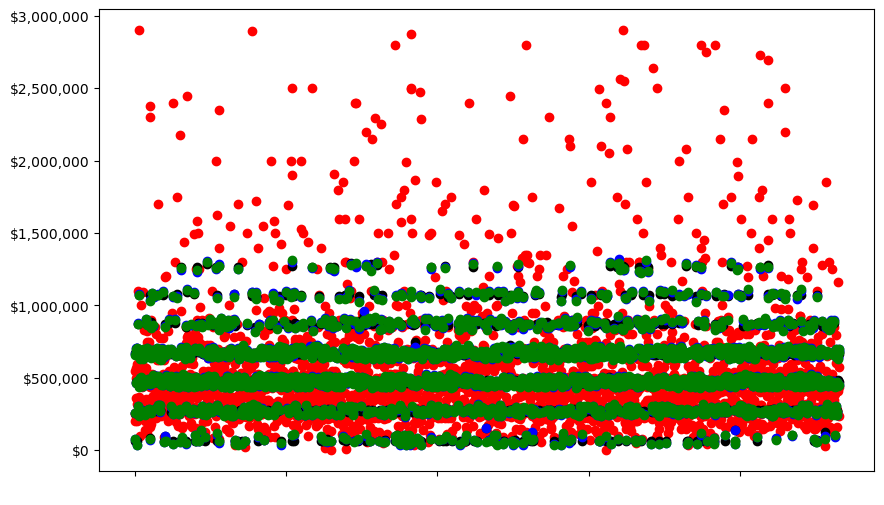

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lgr_sfm_predict_df.index,lgr_sfm_predict_df["prediction"], color="black")
plt.scatter(lgr_rfe_predict_df.index,lgr_rfe_predict_df["prediction"], color="blue")
plt.scatter(lgr_sfs_predict_df.index,lgr_sfs_predict_df["prediction"], color="green")
plt.show()

In [21]:
pipeline_gscv = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('ploy_model', LinearRegression())
])

pipeline_params={"poly_features__degree":[1,2,3,4,5],"poly_features__include_bias":[False],"ploy_model__fit_intercept":[True]}
grid_searchcv = GridSearchCV(pipeline_gscv, param_grid=pipeline_params, cv=5, verbose=1)

In [22]:
grid_searchcv.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('ploy_model', LinearRegression())]),
             param_grid={'ploy_model__fit_intercept': [True],
                         'poly_features__degree': [1, 2, 3, 4, 5],
                         'poly_features__include_bias': [False]},
             verbose=1)

In [23]:
print(f"Best parameters found: {grid_searchcv.best_params_}")

Best parameters found: {'ploy_model__fit_intercept': True, 'poly_features__degree': 1, 'poly_features__include_bias': False}


In [24]:
best_estimator_predict_test = grid_searchcv.best_estimator_.predict(X_test)
print_more_stuff("Polynomial Best Features",y_test,best_estimator_predict_test)

Polynomial Best Features EVS = 0.382049638
Polynomial Best Features MSE = 123,219,782,105.730774
Polynomial Best Features MAE = 227,449.466764
Polynomial Best Features R2 = 0.381894


In [25]:
best_estimator_predict_train = grid_searchcv.best_estimator_.predict(X_train)
#print_more_stuff("Linear Regression Polynomial",y_train,best_estimator_predict_train)

In [26]:
pipeline_params = {}
for what in grid_searchcv.best_params_:
    if pipeline_params.get(what) == None:
        pipeline_params[what] = []
    pipeline_params[what].append(grid_searchcv.best_params_[what])

In [27]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=1,include_bias=False)), 
    ('ploy_model', LinearRegression(fit_intercept=True))
])

poly_grid_searchcv = GridSearchCV(poly_pipeline, param_grid=pipeline_params, cv=5, verbose=1)

poly_grid_searchcv.fit(X_train,y_train)
poly_pipe_predict = poly_grid_searchcv.predict(X_test)
print_more_stuff("Polynomial Features",y_test,poly_pipe_predict)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Polynomial Features EVS = 0.379659525
Polynomial Features MSE = 123,732,449,962.042847
Polynomial Features MAE = 226,349.001399
Polynomial Features R2 = 0.379323


In [28]:
best_estimator_predict_test_df = pd.DataFrame(best_estimator_predict_test).reset_index()
best_estimator_predict_test_df.rename(columns={0: "prediction"},inplace=True)

poly_predict_df = pd.DataFrame(poly_pipe_predict).reset_index()
poly_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_predict_df = pd.DataFrame(lgr_predict).reset_index()
lgr_predict_df.rename(columns={0: "prediction"},inplace=True)

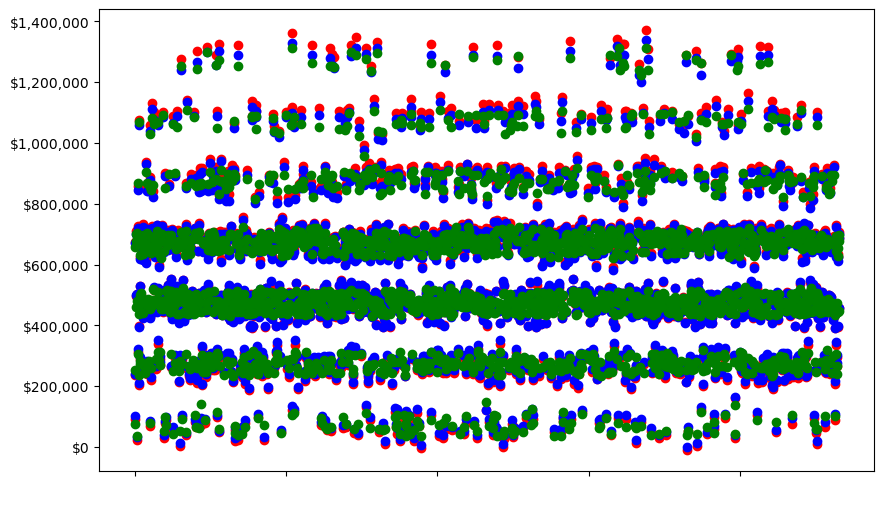

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(best_estimator_predict_test_df.index,best_estimator_predict_test_df["prediction"], color="red")
plt.scatter(poly_predict_df.index,poly_predict_df["prediction"], color="blue")
plt.scatter(lgr_predict_df.index,lgr_predict_df["prediction"], color="green")
plt.show()

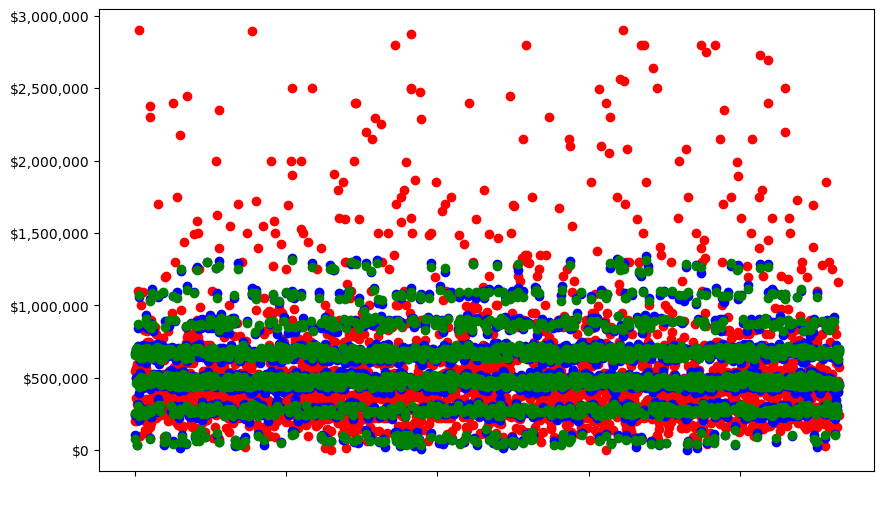

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(poly_predict_df.index,poly_predict_df["prediction"], color="blue")
plt.scatter(lgr_predict_df.index,lgr_predict_df["prediction"], color="green")

In [31]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score
model,,,,
Linear Regression,0.376912030,"226,007.578715","124,292,501,770.902084",0.376513
Recursive Feature Elimination,0.376410322,"226,079.193604","124,390,773,735.619522",0.376020
Sequential Feature Selector,0.376258589,"226,173.387179","124,420,784,521.166824",0.375870
Select From Model,0.374998969,"226,537.206454","124,673,127,989.944580",0.374604
Polynomial Best Features,0.382049638,"227,449.466764","123,219,782,105.730774",0.381894
Polynomial Features,0.379659525,"226,349.001399","123,732,449,962.042847",0.379323
